# Import Necessary package

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import copy
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


# Define NeuralNetwork

In [2]:
# Task2 Model
class NeuralNetwork(nn.Module):
    def __init__(self, features):
        super(NeuralNetwork, self).__init__()

        self.layer1 = nn.Linear(features.shape[1], 256)
        self.layer2 = nn.Linear(256, 128)
        self.layer3 = nn.Linear(128, 64)
        self.output = nn.Linear(64, 4)

    def forward(self, x):
        y_pred = nn.functional.relu(self.layer1(x))
        y_pred = nn.functional.relu(self.layer2(y_pred))
        y_pred = nn.functional.relu(self.layer3(y_pred))
        y_pred = self.output(y_pred)
        return y_pred

# Load Data

In [3]:
df = pd.read_csv("/content/sample_data/Train_Data_final.csv")
df['total cost'] = df['total cost'] - 1
display(df)

,number of rooms,security level of the community,residence space,building space,noise level,waterfront,view,air quality level,aboveground space,basement space,...,zip code_WA 98155,zip code_WA 98166,zip code_WA 98168,zip code_WA 98177,zip code_WA 98178,zip code_WA 98188,zip code_WA 98198,zip code_WA 98199,zip code_WA 98288,zip code_WA 98354
0,5,2.50,2820,67518,2.0,0,0,3,2820,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1.00,1210,9400,1.0,0,0,2,1210,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4,2.50,2200,9397,2.0,0,0,3,2200,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,1.50,1200,9720,1.0,0,0,4,1200,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3,1.75,1370,5858,1.0,0,0,3,1370,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,4,3.50,3840,85728,2.0,0,0,3,3840,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3996,5,2.00,2310,13430,1.5,0,0,4,2310,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3997,4,2.50,3360,22111,2.0,0,0,3,3360,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3998,6,2.50,2640,3680,2.0,0,0,5,1760,880,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

# Training set
train_features = torch.tensor(train_data.drop('total cost', axis=1).values, dtype=torch.float).to(device)
train_labels = torch.LongTensor(train_data['total cost'].values).to(device)

# Validation set
test_features = torch.tensor(test_data.drop('total cost', axis=1).values, dtype=torch.float).to(device)
test_labels = torch.LongTensor(test_data['total cost'].values).to(device)

train_dataset = torch.utils.data.TensorDataset(train_features,train_labels)
test_dataset = torch.utils.data.TensorDataset(test_features,test_labels)
# print(train_dataset.target_tensor) 

# Define the dirichlet distribution function 

In [5]:
def dirichlet_partition(training_data, testing_data, alpha, user_num):
    idxs_train = np.arange(len(training_data))
    idxs_valid = np.arange(len(testing_data))

    # if hasattr(training_data, 'targets'):
    #     labels_train = training_data.targets
    #     labels_valid = testing_data.targets
    # elif hasattr(training_data, 'img_label'):
    #     labels_train = training_data.img_label
    #     labels_valid = testing_data.img_label
    labels_train = train_labels.detach().cpu().numpy()
    labels_valid = test_labels.detach().cpu().numpy()

    idxs_labels_train = np.vstack((idxs_train, labels_train))
    # print("idxs_labels_train 1: ", idxs_labels_train)
    idxs_labels_train = idxs_labels_train[:, idxs_labels_train[1,:].argsort()]
    # print("idxs_labels_train 2: ", idxs_labels_train)
    idxs_labels_valid = np.vstack((idxs_valid, labels_valid))
    idxs_labels_valid = idxs_labels_valid[:, idxs_labels_valid[1,:].argsort()]

    labels = np.unique(labels_train, axis=0)

    data_train_dict = data_organize(idxs_labels_train, labels)
    # print("data_train_dict[0]: ", data_train_dict[0])
    # print("data_train_dict[9]: ", data_train_dict[9])
    data_valid_dict = data_organize(idxs_labels_valid, labels)

    data_partition_profile_train = {}
    data_partition_profile_valid = {}


    for i in range(user_num):
        data_partition_profile_train[i] = []
        data_partition_profile_valid[i] = []

    ## Distribute rest data
    for label in data_train_dict:
        proportions = np.random.dirichlet(np.repeat(alpha, user_num))
        proportions_train = len(data_train_dict[label])*proportions
        proportions_valid = len(data_valid_dict[label]) * proportions

        for user in data_partition_profile_train:

            data_partition_profile_train[user]   \
                = set.union(set(np.random.choice(data_train_dict[label], int(proportions_train[user]) , replace = False)), data_partition_profile_train[user])
            data_train_dict[label] = list(set(data_train_dict[label])-data_partition_profile_train[user])


            data_partition_profile_valid[user] = set.union(set(
                np.random.choice(data_valid_dict[label], int(proportions_valid[user]),
                                 replace=False)), data_partition_profile_valid[user])
            data_valid_dict[label] = list(set(data_valid_dict[label]) - data_partition_profile_valid[user])


        while len(data_train_dict[label]) != 0:
            rest_data = data_train_dict[label][0]
            user = np.random.randint(0, user_num)
            data_partition_profile_train[user].add(rest_data)
            data_train_dict[label].remove(rest_data)

        while len(data_valid_dict[label]) != 0:
            rest_data = data_valid_dict[label][0]
            user = np.random.randint(0, user_num)
            data_partition_profile_valid[user].add(rest_data)
            data_valid_dict[label].remove(rest_data)

    for user in data_partition_profile_train:
        data_partition_profile_train[user] = list(data_partition_profile_train[user])
        data_partition_profile_valid[user] = list(data_partition_profile_valid[user])
        np.random.shuffle(data_partition_profile_train[user])
        np.random.shuffle(data_partition_profile_valid[user])

    return data_partition_profile_train, data_partition_profile_valid


def data_organize(idxs_labels, labels):
    data_dict = {}

    labels = np.unique(labels, axis=0)
    for one in labels:
        data_dict[one] = []

    for i in range(len(idxs_labels[1, :])):
        data_dict[idxs_labels[1, i]].append(idxs_labels[0, i])
    return data_dict


In [43]:
user_num = 4
alpha = 9
train_index, test_index = dirichlet_partition(train_dataset,test_dataset, alpha=alpha, user_num=user_num)
print("train_index[0]：", train_index[0])
print("train_index[1]：", train_index[1])
print("train_index[2]：", train_index[2])
print("train_index[3]：", train_index[3])

train_index[0]： [1325, 2921, 1891, 641, 642, 2591, 2708, 177, 2036, 2983, 1376, 1660, 1263, 2447, 2071, 1479, 821, 1074, 2580, 1301, 2583, 2729, 1028, 3118, 792, 2705, 120, 759, 3104, 223, 1094, 2198, 603, 1208, 1035, 112, 504, 2411, 3177, 2397, 1315, 3128, 233, 1639, 931, 2724, 929, 3179, 2279, 2597, 2551, 778, 1948, 1768, 2687, 2014, 2221, 3023, 2320, 2586, 30, 125, 1283, 2032, 485, 1669, 2760, 59, 2888, 2873, 1401, 2086, 140, 1520, 948, 2270, 1813, 1346, 1227, 1126, 2533, 508, 1013, 2702, 3102, 1755, 2207, 2220, 2225, 3164, 481, 87, 1468, 584, 526, 378, 1495, 685, 2026, 2339, 1461, 1168, 1330, 445, 434, 1704, 2747, 2886, 2203, 1707, 2001, 3158, 2169, 1971, 735, 909, 1478, 2068, 1246, 151, 1162, 638, 458, 975, 1294, 2350, 568, 2264, 1687, 1976, 529, 2982, 1894, 2815, 1622, 2441, 2813, 1155, 158, 2003, 3059, 32, 73, 599, 2788, 121, 1526, 256, 2633, 2476, 686, 524, 1877, 2800, 311, 1831, 403, 117, 437, 1233, 2657, 317, 2255, 1682, 56, 654, 2576, 163, 2620, 2308, 63, 1231, 2468, 180, 14

In [44]:
class DatasetSplit(Dataset):
    """An abstract Dataset class wrapped around Pytorch Dataset class.
    """

    def __init__(self, dataset, idxs):
        self.dataset = dataset
        self.idxs = [int(i) for i in idxs]

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, item):
        data, label = self.dataset[self.idxs[item]]
        return data,label
    
train_data_list = []
for user_index in range(user_num):
    train_data_list.append(DatasetSplit(train_dataset, train_index[user_index]))


In [45]:
batch_size = 4000

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
global_model = NeuralNetwork(train_features).to(device)
train_loader = DataLoader(train_dataset,batch_size = batch_size)
test_loader = DataLoader(test_dataset,batch_size=batch_size)

# Local Training function

In [46]:
def local_trainer(dataset, model, global_round, device, local_epoch,batchsize):

    dataloader = DataLoader(dataset,batch_size=batchsize)
    criterion = nn.CrossEntropyLoss().to(device)
    model.train()
    epoch_loss = []
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    for iter in range(local_epoch):
        batch_loss = []
        for batch_idx, (datas, labels) in enumerate(dataloader):
            datas, labels = datas.to(device), labels.to(device)
            model.zero_grad()
            logits = model(datas)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            if batch_idx % 10 == 0:
                print('| Global Round : {} | Local Epoch : {} | [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    global_round, iter, batch_idx * len(datas),
                    len(dataloader.dataset),
                    100. * batch_idx / len(dataloader), loss.item()))
            batch_loss.append(loss.item())
        epoch_loss.append(sum(batch_loss)/len(batch_loss))
    return model.state_dict(), sum(epoch_loss) / len(epoch_loss)

In [47]:
def inference(model, testloader):
    """ Returns the inference accuracy and loss.
    """
    model.eval()
    criterion = nn.CrossEntropyLoss().to(device)
    loss, total, correct = 0.0, 0.0, 0.0
    for batch_idx, (datas, labels) in enumerate(testloader):
        datas, labels = datas.to(device), labels.to(device)
        # Inference
        outputs = model(datas)
        batch_loss = criterion(outputs, labels)
        loss += batch_loss.item()

        # Prediction
        _, pred_labels = torch.max(outputs, 1)
        pred_labels = pred_labels.view(-1)
        correct += torch.sum(torch.eq(pred_labels, labels)).item()
        total += len(labels)
    loss /= (batch_idx+1)
    accuracy = correct/total
    return accuracy, loss

In [48]:
def average_weights(w):
    """
    Returns the average of the weights.
    """
    w_avg = copy.deepcopy(w[0])
    for key in w_avg.keys():
        for i in range(1, len(w)):
            w_avg[key] += w[i][key]
        w_avg[key] = torch.div(w_avg[key].float(), len(w))
    return w_avg

In [49]:
global_rounds = 50
local_epochs = 100
rounds = []
losses_train = []
losses_test = []
acces_train = []
acces_test = []
count = 0
for round_idx in range(global_rounds):
    local_weights = []
    local_losses = []
    global_acc = []
    rounds.append(round_idx+1)
    for user_index in range(user_num):
        model_weights, loss = local_trainer(train_data_list[user_index], copy.deepcopy(global_model), round_idx, device, local_epochs,batch_size)
        local_weights.append(copy.deepcopy(model_weights))
        local_losses.append(loss)


    global_weight = average_weights(local_weights)
    global_model.load_state_dict(global_weight)
    train_acc,train_loss = inference(global_model,train_loader)
    losses_train.append(train_loss)
    acces_train.append(train_acc)
    print('Global Round :{}, the training accuracy is {:.3}%, and the training loss is {:.3}.'.format(round_idx, 100 * train_acc, train_loss))
    test_acc, test_loss = inference(global_model, test_loader)
    losses_test.append(test_loss)
    acces_test.append(test_acc)
    print('Global Round :{}, the testing accuracy is {:.3}%, and the testing loss is {:.3}.'.format(round_idx, 100 * test_acc, test_loss))

流式输出内容被截断，只能显示最后 5000 行内容。
| Global Round : 37 | Local Epoch : 26 | [0/816 (0%)]	Loss: 0.768856
| Global Round : 37 | Local Epoch : 27 | [0/816 (0%)]	Loss: 0.760565
| Global Round : 37 | Local Epoch : 28 | [0/816 (0%)]	Loss: 0.756331
| Global Round : 37 | Local Epoch : 29 | [0/816 (0%)]	Loss: 0.748724
| Global Round : 37 | Local Epoch : 30 | [0/816 (0%)]	Loss: 0.737556
| Global Round : 37 | Local Epoch : 31 | [0/816 (0%)]	Loss: 0.723224
| Global Round : 37 | Local Epoch : 32 | [0/816 (0%)]	Loss: 0.710188
| Global Round : 37 | Local Epoch : 33 | [0/816 (0%)]	Loss: 0.699184
| Global Round : 37 | Local Epoch : 34 | [0/816 (0%)]	Loss: 0.691353
| Global Round : 37 | Local Epoch : 35 | [0/816 (0%)]	Loss: 0.682966
| Global Round : 37 | Local Epoch : 36 | [0/816 (0%)]	Loss: 0.676744
| Global Round : 37 | Local Epoch : 37 | [0/816 (0%)]	Loss: 0.670046
| Global Round : 37 | Local Epoch : 38 | [0/816 (0%)]	Loss: 0.663943
| Global Round : 37 | Local Epoch : 39 | [0/816 (0%)]	Loss: 0.658541
| Globa

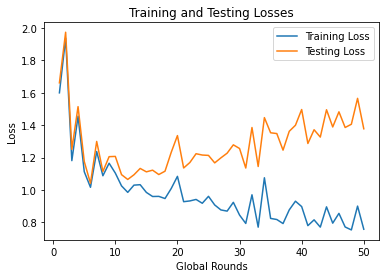

In [50]:
import matplotlib.pyplot as plt
plt.plot(rounds, losses_train, label="Training Loss")
plt.plot(rounds, losses_test, label="Testing Loss")
plt.xlabel("Global Rounds")
plt.ylabel("Loss")
plt.title("Training and Testing Losses")
plt.legend()
plt.savefig('/content/sample_data/loss.png')
plt.show()

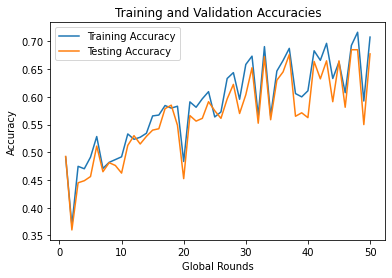

In [51]:
plt.plot(rounds, acces_train, label="Training Accuracy")
plt.plot(rounds, acces_test, label="Testing Accuracy")
plt.xlabel("Global Rounds")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracies")
plt.legend()
plt.savefig('/content/sample_data/Accuracy.png')
plt.show()

In [ ]:
test_data = pd.read_csv("/content/sample_data/Test_Data_adjust.csv")

test_features = torch.tensor(test_data.values, dtype=torch.float).to(device)

global_model.eval()

# Cancel gradient to use model
with torch.no_grad():
    y_pred_test = global_model(test_features)

_, predicted_labels = torch.max(y_pred_test, 1)

predicted_labels_np = predicted_labels.cpu().numpy()

raw_Test_Data = pd.read_csv("/content/sample_data/Test_Data.csv")

raw_Test_Data['total cost'] = predicted_labels_np + 1

raw_Test_Data.to_csv("/content/sample_data/prediction.csv", index=False)